# Project - Sampling for generative models

**Group 6 :** Armand VIOLLE (M2A), Sobihan SURENDRAN (M2A), Amaia CARDIEL (M2A)

**Article 13 :** [Stochastic Variational Inference](https://jmlr.org/papers/volume14/hoffman13a/hoffman13a.pdf)




## 1) Introduction

Our reference article aims at exploring how to use probabilistic graphical models and related posterior inference when the available data is numerous, complex, and high-dimensional. Such datasets usually cannot be dealt with by classic inference algorithms - such as variational inference or MCMC - as they fail to scale. 

A domain of application that is particularly put forward by the article's authors is the analysis of large collections of documents, which precisely requires to approximate posterior distributions in a scalable way.  

## 2) Prerequisite modeling

The proposed algorithm - Stochastic Variational Inference (referenced as "SVI" below) - builds on variational inference, alongside further modeling and optimization choices that we will detail in this second section. 

**a) Building on variational inference**

As for classic variational inference, the aim of SVI is to infer a hidden structure that best explains the observed data in the context of a probabilistic graphical model. Let us thus detail the **variables and dependence structure** used in our model:

* N observations: $x=x_{1:N}$
* N local hidden variables: $z=z_{1:N}$
* Global hidden variables: $\beta$
* Fixed parameters: $\alpha$

Each $x_n$, $z_n$ and $\beta$ variables may be a collection of variables such as, for a given $J$, $z_n=z_{n, 1:J}$. Let us also note that when using the notation $z_{-n}$, we will refer to the set of all $z$ variables except the $n^{th}$ one. 

Each $x_n$ variable only depends on the local hidden variable $z_n$ and on the global hidden variables $\beta$.
The global hidden variables $\beta$ are the only variables that depend on the parameters $\alpha$. This dependence structure leads to the following joint distribution factorization: $p(x,z,\beta| \alpha)=p(\beta | \alpha) \prod_{n=1}^N p(x_n, z_n|\beta)$. 

**Assumptions on the complete conditionals**

The complete conditionals - i.e. the conditional distribution of hidden variables given the other variables - are all assumed to be in the exponential family:

$$
p(\beta |x,z,\alpha)=h(\beta) \exp\{\eta_g(x,z,\alpha)^T t(\beta)-a_g(\eta_g(x,z,\alpha))\}
$$
$$
p(z_{nj} |x_{n},z_{n,-j},\beta)=h(z_{nj}) \exp\{\eta_l(x_n,z_{n,-j},\beta)^T t(z_{nj})-a_l(\eta_l(x_n,z_{n,-j},\beta))\}
$$

Using the exponential family enables us, thanks to conjugacy properties, to deduce that the prior distribution on $\beta$ as well as the complete conditional on the global variables are in a same exponential family, as follows:

$$
p(\beta)=h(\beta)\exp\{\alpha^T t(\beta)-a_g(\alpha)\}
$$
$$
\eta_g(x,z,\alpha)=(\alpha_1+\sum_{n=1}^N t(z_n, x_n), \alpha_2+N)
$$

Let us recall that our primary goal is to approximate the distribution of hidden variables given the observations: $p(\beta, z|x)=\frac{p(\beta, z,x)}{\int p(\beta, z,x)dzd\beta}$. However, for most models, the denominator of this goal distribution in not tractable, which implies the need for an approximation inference algorithm. In the case of our article, the chosen basis will be mean-field variational inference. 

**Mean-Field variational inference**

As seen during the class, variational inference wants to find the best candidate to approximate the posterior distribution among a chosen tractable family, that we name the variational distribution (here $q(z,\beta)$), parameterized by variational parameters (here named $\lambda$ and $\phi_n$). In order to find this best candidate, we use as an **objective function** the evidence lower bound (or ELBO, noted $\mathcal{L}(q)$), a lower bound to the logprobability of the observations. Indeed, using Jensen's inequality thanks to the logarithm concavity, one can show that: $\log p(x) \geq \mathcal{L}(q)$, with $\mathcal{L}(q)$ the sum of two terms depending on $q(z,\beta)$:

$$
\mathcal{L}(q)=\mathbb{E}_q[\log p(x,z,\beta)]-\mathbb{E}_q[\log q(z,\beta)]
$$

Our reference article chooses to restrict $q(z,\beta)$ to the simplest variational family, the so-called mean-field variational family. This implies that each hidden variable only depends on its own parameter ($\lambda$ for the global hidden variables $\beta$, $\phi_{nj}$ for each local hidden variable $z_{nj}$) and is independent from the rest:

$$
q(z,\beta)=q(\beta | \lambda) \prod_{n=1}^N \prod_{j=1}^J q(z_{nj}|\phi_{nj})
$$


The unknown distributions $q(\beta | \lambda)$ and $q(z_{nj}|\phi_{nj})$ are assumed to be in the same exponential family as the complete conditional distributions (with the same functions $t(.)$ and $h(.)$):


$$
q(\beta | \lambda) =h(\beta) \exp\{\lambda^T t(\beta)-a_g(\lambda)\}
$$

$$
q(z_{nj}|\phi_{nj})=h(z_{nj}) \exp\{\phi_{nj}^T t(z_{nj})-a_l(\phi_{nj})\}
$$

**Coordinate ascent**

A classic approach is then to optimize the above-defined objective function $\mathcal{L}(q)$ with respect to $\lambda$ and $\phi_n$, the variational parameters. This is usually performed with a coordinate ascent procedure, where each parameter is updated iteratively while holding the others fixed. All the assumptions made on the model, mean-field family and distributions (with corresponding conditional and variational distributions being in a same exponential family) were made to be able to perform this coordinate optimization in a closed form. Indeed, these assumptions enable us to rewrite the objective function $\mathcal{L}(q)$ as a function of $\lambda$ only ($\mathcal{L}(\lambda)$) to derive its gradient with respect to $\lambda$ and similarly when it comes to $\phi_{nj}$. Indeed, one can prove that:

$$
\mathcal{L}(\lambda)=\mathbb{E}_q[\eta_g(x,z,\alpha)]^T\nabla_{\lambda} a_g(\lambda)- \lambda^T \nabla_{\lambda}a_g(\lambda)+a_g(\lambda)+\text{const}
$$

Thus, we can derive:

$$
\nabla_{\lambda}\mathcal{L}=\nabla_{\lambda}^2 a_g(\lambda)(\mathbb{E}_q[\eta_g(x,z,\alpha)]-\lambda)
$$

Hence:
$$
\nabla_{\lambda}\mathcal{L}=0  \Leftrightarrow \lambda=\mathbb{E}_q[\eta_g(x,z,\alpha)](*)
$$

And similarly,


$$
\nabla_{\phi_{nj}}\mathcal{L}=\nabla_{\phi_{nj}}^2 a_l(\phi_{nj})(\mathbb{E}_q[\eta_l(x_n,z_{n,-j},\beta)]-\phi_{nj})
$$

Hence:
$$
\nabla_{\phi_{nj}}\mathcal{L}=0  \Leftrightarrow \phi_{nj}=\mathbb{E}_q[\eta_l(x_n,z_{n,-j},\beta)](**)
$$

$(*)$ and $(**)$ are the two equations that give the coordinate ascent updates. 



**b) Stochastic optimization and natural gradient** 

In classical gradient ascent methods, updates have the form $\lambda^{(t+1)} = \lambda^{(t)} + \rho \nabla_\lambda f\left(\lambda^{(t)}\right)$, where the gradient points into the direction of the steepest ascent. It is then the same direction than the solution to the problem $\arg \max_{d\lambda} f(\lambda + d\lambda) (*)$ subject to $||d\lambda||^2 < \varepsilon^2$. The issue of this optimization problem in our case lays in the definition of the distance: we want to measure the distance between two probability distributions, so the Euclidean distance can seem inappropriate.

Instead, we're using the symmetrized KL divergence to define a new constraint to the optimization problem $(*)$ :
$D_{KL}^{sym}\left(\lambda,\lambda '\right) = \mathbb{E}_\lambda\left[\log \frac{q(\beta|\lambda)}{q(\beta|\lambda')}\right] + \mathbb{E}_{\lambda'}\left[\log \frac{q(\beta|\lambda')}{q(\beta|\lambda)}\right]$. When using the constraint $D_{KL}^{sym}(\lambda,\lambda+d\lambda) <\varepsilon$, as $\varepsilon \rightarrow 0$, it has be shown that the solution of this new optimization problem points to the same direction than the natural gradient.

Nevertheless, this constraint remains complicated and we manage it with a Riemann metric $G(\lambda)$. This metric defines linear transformations of $\lambda$ under which the squared Euclidean distance between $\lambda$ and $\lambda + d\lambda$ is the symmetrized KL between $q(\beta|\lambda)$ and $q(\beta|\lambda + d\lambda)$ :
$$
D_{KL}^{sym}(\lambda,\lambda+d\lambda) = d\lambda^T G(\lambda)d\lambda
$$

We now define the natural gradient. It is computed by multiplying the gradient by the inverse of the Riemannian metric :
$$
\hat \nabla_\lambda f(\lambda) = G^{-1}(\lambda) \nabla_\lambda f(\lambda)
$$
In our setting, $G(\lambda)$ will be the Fisher information matrix of $q(\lambda)$ : $G(\lambda) = \mathbb{E}_\lambda \left[\left(\nabla_\lambda \log q(\beta|\lambda)\right)\left(\nabla_\lambda \log q(\beta | \lambda)\right)^T\right]$. Using a first-order Taylor approximation on $q(\beta|\lambda + d\lambda)$ and $\log q(\beta|\lambda + d\lambda)$, and using a distribution $q(\beta|\lambda)$ from the exponential family precedently defined, we get : 
$$
D_{KL}^{sym}(\lambda,\lambda+d\lambda) = O(d\lambda^3) + d\lambda^T G(\lambda) d\lambda, ~~~ G(\lambda) = \nabla_\lambda^2 a_g(\lambda)
$$

We've seen previously that for an exponential family, the ELBO can by derived into the following : $\nabla_\lambda \mathcal{L} = \nabla_\lambda^2 a_g(\lambda) \left(\mathbb{E}_q\left[\eta_g(x,z,\alpha)\right]-\lambda\right)$. Then, according to the definition of the natural gradient, we have with respect to the global variational parameter $\lambda$ :
$$
\hat \nabla_\lambda \mathcal{L} = \mathbb{E}_\phi \left[ \eta_g(x,z,\alpha) \right] - \lambda
$$
With analogous computation for local variational parameters $\phi_{n,j}$ :
$$
\hat \nabla_{\phi_{nj}} \mathcal{L} = \mathbb{E}_{\lambda, \phi_{n,-j}} \left[ \eta_l(x_n,z_{n,-j},\beta) \right] - \phi_{nj}
$$


**Stochastic Variational Inference**

Using stochastic optimization, we'll subsample data points form noisy estimates of the ELBO's natural gradient, with  decreasing step-sizes $\rho_t$. 

Recalling the general setting of stochastic optimization, we write $f(\lambda)$ the objective function (the one to optimize) and a random function $B(\lambda)$ such that $\mathbb{E}[B(\lambda)] = \nabla_\lambda f(\lambda)$. At each iteration $t$, drawing independently $b_t$ from $B$, we have :
$$
\lambda^{(t)} = \lambda^{(t-1)} + \rho_t b_t(\lambda^{(t-1)})
$$
Conditions on $\rho_t$ (as defined p.1317 of the article) and the convexity of $f$ ensure to find a global or local optimum. The same result holds if we premultiply by $G_t^{-1}$, as it is a positive-definite matrix, $G_t$ being Fisher metrics as defined previously. We then have :
$$
\lambda^{(t)} = \lambda^{(t-1)} + \rho_t G_t^{-1} b_t(\lambda^{(t-1)})
$$


Pluggin in the results of noisy natural gradients on stochastic optimization, we are then able to optimize the variational objective function. To find the global parameters setting maximizing the ELBO, we want to find $\lambda$ such that $\nabla_\phi \mathcal{L}\left(\lambda,\phi(\lambda)\right) = 0$, the function $\phi$ returning a local optimum of the variational parameters. We then define the locally maximized ELBO $\mathcal{L}(\lambda)$ as the ELBO where $\lambda$ is fixed and $\phi(\lambda)$ is the local optimum : $\mathcal{L}(\lambda)=\mathcal{L}\left(\lambda,\phi(\lambda)\right)$. 

The maximized ELBO can be written as the sum of a global and local terms :
$$
\mathcal{L}(\lambda) = \mathbb{E}_q\left[\log p(\beta)\right] - \mathbb{E}_q\left[\log q(\beta)\right] + \sum_{i=1}^N \max_{\phi_n} \left( \mathbb{E}_q\left[\log p(x_n,z_n|\beta)\right] - \mathbb{E}_q\left[\log q(z_n)\right] \right)
$$
Considering the random variable $I\sim\mathcal{U}\left(\{1,...,N\}\right)$ drawing randomly an index from the dataset, we can define a noisy natural gradient :
$$
\mathcal{L}_I(\lambda) = \mathbb{E}_q\left[\log p(\beta)\right] - \mathbb{E}_q\left[\log q(\beta)\right] + N \max_{\phi_n} \left( \mathbb{E}_q\left[\log p(x_I,z_I|\beta)\right] - \mathbb{E}_q\left[\log q(z_I)\right] \right)
$$
This results holds thanks to an equality in expectations of the local term. We can then use noisy estimates of the $\hat\nabla_\lambda \mathcal{L}$ with $\hat\nabla_\lambda \mathcal{L}_I$, and using the expressions found earlier on the dataset $\left\{(x_I^{(N)},z_I^{(N)}\right\}$ formed of $N$ repetitions of the data point indexed by $I$, we have according to the expression of $\eta_g$ :
$$
\hat\nabla_\lambda \mathcal{L}_I = \mathbb{E}_q\left[\eta_g(x_I^{(N)},z_I^{(N)},\alpha)\right] - \lambda = \alpha + N \left(\mathbb{E}_{\phi_I(\lambda)}\left[t(x_I,z_I)\right],1\right) - \lambda
$$

We can see that the noisy natural gradient only uses the I-th data point sampled from the original dataset as well as its corresponding local optimum $\phi_I(\lambda)$, whereas the full natural gradient would consider all of the data points. As a consequence, it is computationally cheaper to use noisy natural gradients.

The conclusion to all of these considerations is a new update in the stochastic optimization algorithm, using noisy intermediate estimates of $\lambda$ that we write $\hat\lambda_t$. As we're trying to maximize the local ELBO $\mathcal{L}_I$, we want its gradient to equal 0, which, according to the previous equation, gives us $\hat\lambda_t = \alpha + N \left(\mathbb{E}_{\phi_I(\lambda)}\left[t(x_I,z_I)\right],1\right)$. Plugging that definition into the general update rule, we finally get the update for our stochastic variational inference optimization algorithm :
$$
\lambda^{(t)} = \lambda^{(t-1)} + \rho_t\left(\hat\lambda_t - \lambda^{(t-1)}\right) = (1-\rho_t)\lambda^{(t-1)} + \rho_t\hat\lambda_t 
$$

Finally, the proposed algorithm :

* Initialize $\lambda^{(0)}$ randomly.
* Set step-size schedule $\rho_t$ appropriately.
* $\textbf{Repeat}$
  * Sample a document $x_i$ uniformly from the dataset.
  * Compute its local variational parameter : $\phi = \mathbb{E}_{\lambda^{(t-1)}} \left[\eta_g(x_i^{(N)},z_i^{(N)})\right]$
  * Compute intermediate global parameters as though $x_i$ is replicated $N$ times : $\hat\lambda = \mathbb{E}_{\phi} \left[\eta_g(x_i^{(N)},z_i^{(N)})\right]$
  * Update the current estimate of the global variaitional parameters : $\lambda^{(t)} = (1-\rho_t)\lambda^{(t-1)} + \rho_t \hat\lambda$
* $\textbf{until}$ forever

**c) Topic model**

Topic modeling is a probabilistic modeling technique used in Natural Language Processing to detect recurring patterns of word usage in collections of documents, without prior knowledge of the content. The goal is to discover underlying topics in the text data. This technique can be used for descriptive tasks, such as creating thematic navigators of large document collections, as well as for predictive tasks, like document classification. 

Latent Dirichlet Allocation (LDA) is a widely used algorithm for topic modeling. It is an unsupervised probabilistic model that shares some similarities with clustering algorithms (Expectation-Maximization), as both use iterative optimization. However, these methods differ in their model structures. LDA works by assuming that each document is a mixture of multiple topics, and that each topic is a probability distribution over a set of words. It uses Dirichlet distribution to find topics for each document and words for each topic. The Dirichlet distribution of order $K$ with parameters $\gamma_1, ..., \gamma_K > 0$ has a probability density function with respect to Lebesgue measure given by:

$$ \text{Dirichlet}(\theta; \gamma) = \frac{\Gamma\biggl(\sum_{i=1}^{K} \gamma_i\biggr)}{\prod_{i=1}^{K} \Gamma(\gamma_i)} \prod_{i=1}^{K} \theta_i^{\gamma_i - 1} $$

where $\theta$ belongs to the standard $K-1$ simplex.


$\textbf{Notation}$ : 
* $\alpha$ and $\eta$ are parameters of the prior distributions over $\theta$ and $\beta$
* $w_{d,n}$ is the $n$th word of the $d$th document
* $z_{d,n}$ is the index of the topic for the $n$th word in the $d$th document
* $\beta_k$ is the distribution of words for topic $k$ (vector of length $V$)
* $\theta_d$ is the distribution of topics for document $d$ (vector of length $K$)


![LDA](https://i.stack.imgur.com/3Qny2.png)

It is assumed that there are a total of $V$ different words in the vocabulary, that these words can be drawn and that there are $D$ documents. Each document is assumed to be composed of a mixture of these $K$ topics. Specifically, for each document $d$, we have a vector $\theta_d$ whose elements represent the proportion of the document that is made up of each topic. Finally, we assume that each word in each document was drawn from a unique topic. 

The generative process for LDA is then:
* Draw topics $\beta_k \sim \text{Dirichlet}(\eta,\dots,\eta)$ for $k \in \left\{1,\dots,K\right\}$.
* For each document $d \in \left\{1,\dots,D\right\}$:
  * Draw topic proportions $\theta_d \sim \text{Dirichlet}(\alpha,\dots,\alpha)$.
  * For each word $n$ in document $d$:
    * Draw a topic assignment $z_{dn} \sim \text{Multinomial}(\theta_d)$.
    * Draw a word $w_{dn} \sim \text{Multinomial}(\beta_{z_{dn}})$.



## 3) Proposed algorithm

In this section, we extend the stochastic variational inference algorithm for the LDA topic model. Computing the posterior distribution of LDA is often intractable, which presents a central computational challenge in topic modeling. To address this challenge, various approximation methods, such as Markov chain Monte Carlo and variational inference, have been developed. One such method is stochastic variational inference for LDA, which is a scalable version of the original variational algorithm that can handle large collections of documents. This method uses mean-field variational inference and assumes that the complete conditional is in the exponential family as discussed in previous sections. Assuming the same distributional assumptions as in the previous sections for the variables and using the first derivative of the log Gamma function, $\Psi(\cdot)$:
$$
\mathbb{E}\left[ \log \theta_k \mid \gamma \right] = \Psi\left(\gamma_{k}\right) - \Psi\left(\sum_{i=1}^{K} \gamma_{i}\right)
$$

The authors have shown the following equations:


$$ \phi_{k,d,n} \propto \exp \left\{ \Psi \left( \gamma_{d,k}\right) + \Psi \left( \lambda_{k,w_{d,n}}\right) - \Psi\left(\sum_v \lambda_{k,v}\right) \right\} \text{ for } n \in \{1, \dots, N\} $$

$$ \gamma_{d} = \alpha + \sum_{n=1}^{N} \phi_{d,n} $$


$$ \lambda_{k} = \eta + \sum_{d=1}^{D} \sum_{n=1}^{N} \phi^{k}_{d,n} w_{d,n} $$

where the parameter $\lambda_{k}$ represents the Dirichlet distribution parameters for the variational distribution of the topic $\beta_{k}$. It gives the following stochastic variational inference algorithm for LDA:

**Algorithm**

* Initialize $\lambda^{(0)}$ randomly.
* Set step-size schedule $\rho_t$ appropriately.
* $\textbf{Repeat}$
  * Sample a document $w_d$ uniformly from the dataset.
  * Initialize $\gamma_{d,k} = 1$, for $k \in {1, ..., K}$.
  * $\textbf{Repeat}$
    * For $n \in { 1, ..., N }$ set :
      * $\phi_{d,n,k} \propto \exp({\mathbb{E}[\log\theta_{d,k}] + \mathbb{E}[\log\beta_{k,w_{d,n}}]})$,  $k \in {1, ..., K}$.

    * Set $\gamma_d = \alpha + \sum_n \phi_{d,n}$.

  * $\textbf{until}$ local parameters $\phi_{d,n}$ and $\gamma_d$ converge
  * For $k \in {1, ..., K}$ set intermediate topics :
    * $\hat{\lambda_{k}} = \eta + D \sum_{n} \phi^{k}_{d,n} w_{d,n}$.
  * Set $\lambda^{(t)} = (1 - \rho_t)\lambda^{(t-1)} + \rho_t\hat{\lambda}$.
* $\textbf{until}$ forever



## 4) Implementation

In this section, we chose to implement the stochastic variational inference algorithm for LDA, as described at the end of the previous section. 

In [1]:
"""""""""""""""""
Required packages
"""""""""""""""""
import time
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import nltk
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from scipy.special import digamma 
from scipy.stats import dirichlet
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import string
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/Etu4/3310264/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get the working directory's path whether one uses Google Colab or not

if get_ipython().__class__.__module__ == "google.colab._shell":
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/modgen/'
else:
    import os
    path = os.getcwd() 

* **Datasets**

To implement the algorithm, we chose to use collections of articles or media posts, under the format of a list of strings. Let us first mention that we chose to use datasets that have thematic labels for each document or article. This choice was made in order to make the hyperparameter selection and the result evaluation phases easier. Indeed, the number of different thematic labels gave us a first indication on what could be a good choice for the K parameter (number of topics to evaluate). Furthermore, having a thematic list will help us evaluate (quite "subjectively") if the topic list found seems to display similar themes.

Our first dataset, **20 newsgroup**, contains 11,314 media posts ("tweet" like short messages), for a total of 3,135,979 words. For each post, a thematic label among 20 in total is given (cf the code below for the complete thematic list). It is available on scikit-learn. Its media posts being quite short (80 to 300 words), this was a way to develop and test our code on a light dataset. Our very first experiment was even made on a subsection of this dataset, restrained to $\approx$ 1000 media posts labelled with 2 different themes only (such as religion and medecine for instance). This subdataset still accounts for a total of 337,979 words.

In [32]:
news = datasets.fetch_20newsgroups(remove=('headers','footers','quotes'))
print("\nList of the 20 thematic labels:")
print(list(news.target_names))
print("\nDimension of the 20 newsgroup dataset:\n", len(news.target), "media posts")
print("\nVisualization of a sample media post from the dataset:")
print(news.data[0])


List of the 20 thematic labels:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Dimension of the 20 newsgroup dataset:
 11314 media posts

Visualization of a sample media post from the dataset:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking ca

Our second dataset, **BBC News Archive** is made of 2,225 news article from the BBC, for a total of 943,501 words. The articles were much longer in this dataset (from a minimum of 500 words to a maximum of 25,483, with an average length of 2,262 words). As a result, this dataset was much closer to the type of data described in the article. Let us still note that the number of articles available in this collection is very limited in terms of magnitude when compared to the collections used in the reference paper (i.e. 350,000 articles from Nature, 1.8M articles from the New York Times, 3.8M articles from Wikipedia).

This dataset is labelled with each article being given a theme among the following five: **business, entertainment, politics, sport and tech**. As a side note, this dataset was found on a kaggle contest webpage (https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive) and after some preprocessing we worked on the basis of a single csv file, named "bbc-news-data.csv", given along this notebook. **One should put the 'bbc-news-data.csv' csv file in a folder named 'BBC_data' next to this notebook**.


In [4]:
bbc = pd.read_csv(path+'/BBC_data/bbc-news-data.csv')['Text'].values
print("\nDimension of the BBC news dataset: \n", len(bbc), "news articles")
print("\nVisualization of a sample article from the dataset:")
print(bbc[0])


Dimension of the BBC news dataset: 
 2225 news articles

Visualization of a sample article from the dataset:
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 a

* **Details on the algorithm implementation**

When implementing the stochastic variational inference for LDA, the computation of the $\phi_{d,n,k} \propto \exp({\mathbb{E}[\log\theta_{d,k}] + \mathbb{E}[\log\beta_{k,w_{d,n}}]})$ is to be considered carefully. 

First, we have to set two Dirichlet variables ($\theta$ and $\beta$) to the logarithm before taking the expectation. We could implement these expectations through the formula given in the paper p.1325, equation (27): $\mathbb{E}[\log\theta_{k}|\gamma]= 𝚿(\gamma_k)- 𝚿(\sum_{i=1}^K \gamma_i)$. The same formula applies for $\mathbb{E}[\log\beta_{k,w_{d,n}}|\lambda]$. (In the code, we named these equations E1 and E2 respectively).

A second issue is due to the $\propto$ relation that required us to normalize the $\phi_{n,k}$ values to avoid explosive values. We chose to normalize, for a fixed $n$, the $\phi_{n,k}$ values by the sum of all $\phi_{n,k}$ for $k \in \{1,...,K\}$ (this is the 1-norm as all $\phi_{n,k}\geq0$). This enabled us to avoid any nan values in our experiments. 

Finally, let us note that the algorithm starts with the initialization of $\lambda^{(0)}$ randomly. However, as given in the article, the algorithm does not specify how to draw such $\lambda^{(0)}$. After some tests, we chose to initialize via the uniform law (with bounds 0.5 and 1.5).

* **Metric** 

We included in our code a function (named 'log\_prob') to compute the metric described in the paper, p. 1336, in order to evaluate the model fitness. As our algorithm returns K distributions over the vocabulary (i.e. K topics) after learning on the training dataset, the metric finetunes the found distribution on a subset of unique words taken from a test document, named $w_{obs}$ words, before evaluating the log probability of the other unseen words of the same test document, named $w_{ho}$, under this finetuned distribution. The probability of a $w_{ho}$ word is defined as:

$$p(w_{ho}|\mathcal{D}, w_{obs}) ≈ \sum_{k=1}^K \mathbb{E}_q[\theta_k]  \mathbb{E}_q[\beta_{k,w_{ho}}]$$

with $q(\beta)$ depending on the training data $\mathcal{D}$ and $q(\theta)$ depending on $q(\beta)$ and $w_{obs}$. Furthermore, the formula that we used to compute the expectation of a Dirichlet variable like $\theta$ and $\beta$ is, as given in the paper p.1325: 

$$\mathbb{E}_q[\theta_k|\gamma]=\frac{\gamma_k}{\sum_{i=1}^K \gamma_i}$$

Finally, let us note that this metric, based on the progression of the log probability of unseen data, can be used to make sure that it is indeed increasing through training and that it stabilizes at the end. This phenomenon can be seen on the paper's curves such as in figure 7 p.1328 and we will show later that we found similar results. The stabilization of the log probability itself enables us to know that the training has converged towards a local optimum, but this metric cannot prove that the algorithm's results will be satisfying. As this algorithm is related to unsupervised learning, it is hard to evaluate its quality. Again, this is the reason why we chose to work with datasets that have thematic labels. Though different from topics, these labels will help us evaluate subjectively whether the found results seem satisfying.

* **Hyperparameters**

**K** is the number of topics to compute. Though K=100 is recommended in the article, we chose most of the time to set K to the number of labels. 

**alpha** is the dirichlet prior for $\beta$. We followed the article's recommendation to set it to 1/K.

**eta** is the dirichlet prior for $\theta$. We followed the article's recommendation to set it to 0.01.

**T** is a parameter that we used to encode the maximal number of iterations in both our update loops (local and global) for simplicity.

**epsilon** is a threashold parameter that we used to stop our update loops if the gamma values did not evolve or to avoid dividing $\phi_{n,k}$ by a value that is too small during its normalization phase. 

2 parameters control the learning rate **rho_t** since we defined it, like in the reference paper, as: $\rho_t=(t+\tau)^{-κ}$.

The **forgetting_rate** $κ$ controls the speed at which the algorithm should forget old values. $κ$=0.5 or 0.6 is recommended in the article but we chose a higher value of 1 as it appeared to us that it led to better results after running comparative tests. As a result, our algorithm will forget more slowly the old information than in the article. 

**tau** ($\tau \geq0$) is a delay that is meant to down-weight the impact of early iterations. As in the paper, we used tau=1.

### a) Pre-processing the dataset and vocabulary

**Warning**: This section requires heavy computations. Therefore, one can avoid running the cells from this section as the results of this preprocessing phase can be directly loaded after section a).

* **Loading the desired dataset**

The user can choose which dataset to use, through the CHOSEN_DATASET global variable, among :

* a subsection of 10% of the 20 newsgroup dataset with a 'small' vocabulary of $\approx$ 2,100 words ("20NG_2_themes_small_vocab")

* a subsection of 10% of the 20 newsgroup dataset with a 'large' vocabulary of $\approx$ 3,700 words ("20NG_2_themes_large_vocab")

* the entire 20 newsgroup dataset ("20NG")

* the BBC news dataset ("bbc"). 

In [3]:
# GLOBAL VARIABLE DEFINITION
# Choose among "bbc", "20NG", "20NG_2_themes_small_vocab", "20NG_2_themes_large_vocab"

CHOSEN_DATASET = "bbc" 

In [4]:
# Loading the chosen dataset

if CHOSEN_DATASET=="20NG": 
    newsgroups = datasets.fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))
    dataset = newsgroups.data
    K=20
    save_path=path+'/20NG_data/'
    max_freq, min_freq = 1, 1e-5 # limit frequencies of kept words in the vocabulary
    
elif CHOSEN_DATASET=="20NG_2_themes_small_vocab": 
    cats = ['sci.med', 'soc.religion.christian']
    newsgroups = datasets.fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'),categories=cats)
    dataset = newsgroups.data
    K=2
    save_path=path+'/20NG_2_themes_data/'
    max_freq, min_freq = 1, 1e-4 # for a vocabulary of 2162 words
    
elif CHOSEN_DATASET=="20NG_2_themes_large_vocab": 
    cats = ['sci.med', 'soc.religion.christian']
    newsgroups = datasets.fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'),categories=cats)
    dataset = newsgroups.data
    K=2
    save_path=path+'/20NG_2_themes_data/'
    max_freq, min_freq = 1, 1e-5*5 # for a vocabulary of 3747 words
    
elif CHOSEN_DATASET=="bbc": 
    save_path=path+'/BBC_data/'
    dataset = pd.read_csv(save_path+'bbc-news-data.csv')['Text'].values
    K=5
    max_freq, min_freq = 1, 1e-5 

In [5]:
# Lower and tokenize the data if documents are under string format (on a sentence-level)

def lower_tokenize_dataset(dataset):
    """
    Inputs
    ----------
    dataset: chosen dataset as a list of articles or posts (in string format)

    Outputs
    -------
    tokenized_dataset: dataset as a list of lists of tokenized, lower-case, words
    """
    
    tokenized_dataset=[]
    for document in dataset:
        document = document.lower() # set all words to lowercase
        # let's tokenize: each post is transformed from a sentence-level string to a list of word-level strings
        document = wordpunct_tokenize(document) 
        tokenized_dataset.append(document)
    return tokenized_dataset

In [6]:
tokenized_dataset = lower_tokenize_dataset(dataset)

In [7]:
np.random.seed(0) 
train_dataset, test_dataset = train_test_split(tokenized_dataset, test_size=0.1, shuffle=True)

* **Extracting the Vocabulary**

As recommended in the article, we used a 'stopword' list of words that should not be included in the vocabulary as they are very common and have low semantic meaning, such as "with", "for", etc. We added to the native stopword list of the NLTK library (179 words), a stopword list of 851 words that we found at the following link: https://countwordsfree.com/stopwords. **One should have the file 'stop_words_english.json' in the same directory as this notebook.**

Furthermore, the variables **max_freq** and **min_freq** (defined in a python cell above) are the limit frequencies of kept words in the built vocabulary for each dataset. As in the article, filtering according to the frequency will enable us to reduce the size of the vocabulary. Computations will be faster and results better if we make sure that we keep the words with the most semantic values. This frequency filter made the BBC vocabulary go from $\approx$ 25,000 words to $\approx$ 10,000 words, the (complete) 20 newsgroup vocabulary go from $\approx$ 78,000 words to $\approx$ 11,500 words. We tried two different frequency filters for the 20 newsgroup dataset restrained to 2 themes ; these filters made its vocabulary go from $\approx$ 17,000 words to $\approx$ 3,700 words (for a 'large' vocabulary) or to $\approx$ 2,100 words (for a 'small' vocabulary). We chose to build vocabularies of such sizes, in order to be close to the length of the article's vocabularies (ranging between 4,200 and 8,000 words). 

In [8]:
# List of stopwords
nltk_stopwords = (stopwords.words('english'))
with open('stop_words_english.json') as stop_file:
    additional_stopwords = json.load(stop_file)
our_stopwords = nltk_stopwords+additional_stopwords

# List of punctuations
Punctuations = list(string.punctuation)

In [9]:
def extract_vocab(dataset, max_freq=1, min_freq=0, our_stopwords=our_stopwords, Punctuations=Punctuations):
    """
    Inputs
    ----------
    dataset: dataset as a list of lists of tokenized, lower-case, words
    max_freq: frequency upper bound of kept words in the vocabulary
    min_freq: frequency lower bound of kept words in the vocabulary
    our_stopwords: list of words to erase from the vocabulary
    Punctuations: list of punctuation caracters to erase from the vocabulary and kept words
    
    Outputs
    -------
    Vocabulary_list: Final vocabulary as a list of words (under string format)
    """
    
    Vocabulary = {} # declare Vocabulary as a dictionary
    for document in dataset:
        for word in document:
            # remove punctuations and stopwords
            if word not in Punctuations and word not in our_stopwords:
                # remove punctuations that were left in the vocabulary's tokens
                word = word.translate(str.maketrans('', '', ''.join(Punctuations)))
                # remove empty words or words with less than 4 caracters
                if len(word)>3:
                    if word in Vocabulary.keys():
                        Vocabulary[word]+=1
                    else:
                        Vocabulary[word]=1

    # let's remove the words that are too frequent or too rare
    Nb_words = sum(Vocabulary.values())
    for key in list(Vocabulary.keys()):
        if (Vocabulary[key]/Nb_words>max_freq) or (Vocabulary[key]/Nb_words<min_freq):
            Vocabulary.pop(key)
    
    Vocabulary_list = list(Vocabulary.keys())
    
    return Vocabulary_list

In [10]:
Vocabulary = extract_vocab(train_dataset, max_freq=max_freq, min_freq=min_freq)
print("Number of words in the Vocabulary: V=", len(Vocabulary))

Number of words in the Vocabulary: V= 2162


* **Words encoding**

In [11]:
def onehot_encoding_word(voc, word):
    """
    Inputs
    ----------
    voc: vocabulary
    word: word under string format to encode
    
    Outputs
    -------
    idx: integer index of the word in the vocabulary
    """
    
    idx = np.where(np.array(voc) == word)[0][0]
    return idx

def onehot_encoding_doc(voc, doc):
    """
    Inputs
    ----------
    voc: vocabulary
    doc: document (article or post) to encode as a list of words under string format
    
    Outputs
    -------
    encoded_doc: list of integer indices of the document's words with respect to the vocabulary
    """
    
    encoded_doc = []
    for word in doc:
        if word in voc:
            encoded_doc.append(onehot_encoding_word(voc, word))
    return encoded_doc

def onehot_dataset(dataset, voc):
    """
    Inputs
    ----------
    dataset:  dataset to encode 
    voc: vocabulary
    
    Outputs
    -------
    clean_encoded_dataset: list of lists of integer indices of the documents' words with respect to the vocabulary
    """
    
    clean_encoded_dataset = [onehot_encoding_doc(voc, doc) for doc in tqdm(dataset)]
    return clean_encoded_dataset

In [12]:
def preprocess_test_dataset(dataset, vocab, w_obs_prop):
    """
    Inputs
    ----------
    dataset: test dataset containing documents to split 
    vocab: vocabulary
    w_obs_prop: proportion of a document's words that we assign to the w_obs words list (instead of w_ho list)
    
    Outputs
    -------
    dataset_w_obs: dataset of the same length as 'dataset' where each document only contains the w_obs words
    dataset_w_ho: dataset of the same length as 'dataset' where each document only contains the w_ho words
    """
    
    dataset_w_ho = []
    dataset_w_obs = []

    for document in tqdm(dataset):
        document_words_set = set()
        for word in document:
            if word in vocab:
                idx_word = onehot_encoding_word(vocab, word)
                document_words_set.add(idx_word)
                
        document_words_set = list(document_words_set)
        
        # we want to have at least 3 words in a test document to use it for evaluation
        if len(document_words_set)>2:
            kept_prop = int(len(document_words_set)*w_obs_prop)
            dataset_w_obs.append(document_words_set[:kept_prop])
            dataset_w_ho.append(document_words_set[kept_prop:])
    
    return dataset_w_obs, dataset_w_ho

In [ ]:
start=time.time()
train_dataset_onehot = onehot_dataset(train_dataset, Vocabulary)
end=time.time()
print("\nExtraction time for train_dataset:", end-start)

In [ ]:
start=time.time()
test_dataset_w_obs, test_dataset_w_ho = preprocess_test_dataset(test_dataset, Vocabulary, w_obs_prop=0.70)
end=time.time()
print("\nExtraction time for test_dataset:", end-start)

Let us save the pre-processed datasets (this way, one will be able to avoid running the cells from section a) and directly run the cells of sections b) and c)). To run the following cell to save the data, **one should have folders in the working directory, named "20NG_2_themes_data", "20NG_data" and "BBC_data"**.

In [15]:
with open(save_path+CHOSEN_DATASET+'_Vocabulary.txt', 'w') as f:
    json.dump(Vocabulary, f, ensure_ascii=False)

with open(save_path+CHOSEN_DATASET+"_train_data", "wb") as f1:  
    pickle.dump(train_dataset_onehot, f1)

with open(save_path+CHOSEN_DATASET+"_test_data_w_obs", "wb") as f2:  
    pickle.dump(test_dataset_w_obs, f2)

with open(save_path+CHOSEN_DATASET+"_test_data_w_ho", "wb") as f3:  
    pickle.dump(test_dataset_w_ho, f3)

### b) Proposed algorithm

In [3]:
def get_word_from_index(voc, idx_word):
    """
    Inputs
    ----------
    voc: vocabulary
    idx_word: integer index of the considered word in the vocabulary
    
    Outputs
    -------
    word: decoded word under string format
    """
        
    word = voc[idx_word]
    return word

In [4]:
class stochastic_variational_inference():
    def __init__(self, params):
        """
        Inputs
        ----------
        params: dictionary containing all hyperparameters
        """
        
        self.D = params['D'] # number of documents in the collection
        self.V = params['V'] # vocabulary's length
        self.Vocabulary = params['Vocabulary'] # vocabulary 
        self.K = params['K'] # number of topics 
        self.alpha = params['alpha'] # dirichlet prior for beta
        self.eta = params['eta'] # dirichlet prior for theta 
        self.T = params['T'] # maximal number of update iterations
        self.epsilon = params['epsilon'] # threashold to test whether the gamma values stay "constant"
        # parameters to control the learning rate 
        self.forgetting_rate = params['forgetting_rate'] # forgetting_rate
        self.tau = params['tau'] # delay
        self.rho_t = None # learning rate 


    def one_step(self,documents,lamb):
        """
        Inputs
        ----------
        documents: the list of documents
        lamb: current estimation of lambda
        
        Outputs
        -------
        lamb: new estimation of lambda
        gamma_new: new estimation of gamma
        """
        
        # case where we use one_step in the 'forward' method
        if len(documents)>1:
            d = np.random.choice(self.D)
            document = documents[d]
        # case where we use one_step in the 'log_prob' method
        else:
            document = documents[0]

        N = len(document) 
        phi = np.zeros((self.K,N))
        gamma_new = np.ones(self.K)
        gamma_old = np.inf

        i = 0
        
        # E2 = E[log beta]
        E2 = digamma(lamb) - digamma(np.sum(lamb, 1))[:, np.newaxis] 

        # local updates 
        while (i < self.T) and (np.linalg.norm(gamma_old - gamma_new) >= self.epsilon):

            gamma_old = gamma_new

            # E1 = E[log theta]
            E1 = digamma(gamma_old) - digamma(np.sum(gamma_old))

            for n in range(N):    
                phi[:,n] = np.exp(E1 + E2[:,document[n]])
                phi_sum = np.sum(phi[:,n])
                if phi_sum<self.epsilon:
                    phi[:,n]=phi[:,n]/phi_sum

            gamma_new = self.alpha + np.sum(phi, axis = 1)
            i += 1
        
        # global update 
        lamb_hat = np.zeros_like(lamb)
        for k in range(self.K):
            S = np.zeros(self.V)
            for n in range(N):
                S[document[n]] += phi[k,n]

            lamb_hat[k] = self.eta + self.D * S       

        lamb = (1-self.rho_t) * lamb + self.rho_t * lamb_hat
        return lamb, gamma_new

    def log_prob(self, lamb, test_dat_obs=None, test_dat_ho=None):
        """
        Inputs
        ----------
        lamb: current estimation of lambda
        test_dat_obs: a set of observed words
        test_dat_ho: a set of held-out words
        
        Outputs
        -------
        log_prob: log predictive probability
        """
        
        log_prob = 0.
        for test_doc_obs, test_doc_ho in zip(test_dat_obs, test_dat_ho):
            temp_lamb, temp_gam = self.one_step([test_doc_obs], lamb)
            esp_theta = temp_gam / np.sum(temp_gam)
            esp_beta = temp_lamb / np.sum(temp_lamb, axis=1)[:, np.newaxis]
            log_p_new = np.log(esp_theta[:,np.newaxis].T @ esp_beta)[0] # vector of log prob 
            eval_log_p_new=[log_p_new[word] for word in test_doc_ho]
            log_prob += np.mean(eval_log_p_new)

        return log_prob / len(test_dat_ho)

    def forward(self, train_dat, eval=False, test_dat_obs=None, test_dat_ho=None, graph=False):
        """
        Inputs
        ----------
        train_dat: list of documents for training
        eval: boolean parameter that indicates whether log predictive probability will be computed or not
        test_dat_obs: a set of observed words
        test_dat_ho: a set of held-out words
        graph: boolean parameter that indicates whether the graph of log predictive probability will be displayed or not
        
        Outputs
        -------
        lamb: final estimation of lambda
        log_p: log predictive probability
        """
        
        lamb = np.random.uniform(low=0.5, high=1.5, size=(self.K, self.V))
        log_p = []
        for t in tqdm(range(1, self.T + 1)):
            self.rho_t = pow(t + self.tau, -self.forgetting_rate)
            lamb, gam = self.one_step(train_dat, lamb)
            if eval and (t%10)==0:
                log_p.append(self.log_prob(lamb, test_dat_obs, test_dat_ho))
        
        if graph:
            plt.figure()
            plt.plot(np.arange(len(log_p))*10, log_p)
            plt.xlabel('Iterations')
            plt.ylabel("Mean log probability metric")
            plt.show()
        return lamb, log_p
    

    def pred_topics(self, lamb, nb_words, display_topics=False):
        """
        Inputs
        ----------
        lamb: current estimation of lambda
        nb_words: number of words to display in each topic
        display_topics: boolean parameter that indicates whether topics will be displayed or not

        Outputs
        -------
        topics: list of topics
        """
        
        esp_beta = lamb / np.sum(lamb, axis=1)[:, np.newaxis]
        sorted_esp_beta = np.argsort(esp_beta, axis=1)[:,-nb_words:] # sort in increasing order
        topics=[]
        for k in range(self.K):
            topic_k=[get_word_from_index(self.Vocabulary, idx) for idx in (sorted_esp_beta[k,:][::-1])]
            topics.append(topic_k)
        """
        if display_topics:
            for i, topic in enumerate(topics):
                print(f"\nTop {nb_words} words for topic n°{i+1}")
                for word in topic:
                    print(word)
        """
        if display_topics:
            for i, topic in enumerate(topics):
                print(f"\nTop {nb_words} words for topic n°{i+1}")
                print(topic)
        return topics 

### c) Experimental results

One can use the next function ('loading_preprocessed_data') to load directly the pre-processed vocabulary and datasets built in section a) without running section a)'s cells. This function will also build the parameters for the Stochastic variational inference algorithm. 

The user can choose from which dataset to load the preprocessed data, through the **CHOSEN_DATASET** global variable, among :

* a subsection of 10% of the 20 newsgroup dataset with a 'small' vocabulary of $\approx$ 2,100 words ("20NG_2_themes_small_vocab")

* a subsection of 10% of the 20 newsgroup dataset with a 'large' vocabulary of $\approx$ 3,700 words ("20NG_2_themes_large_vocab")

* the entire 20 newsgroup dataset ("20NG")

* the BBC news dataset ("bbc"). 

In this section, we will run various topic inferences, visualize the metric as well as the top 10 words in the found topics (as topics are distributions).

In [5]:
def loading_preprocessed_data(CHOSEN_DATASET, path=path):
        
    if CHOSEN_DATASET=="20NG": 
        K=20
        save_path=path+'/20NG_data/'

    elif CHOSEN_DATASET=="20NG_2_themes_small_vocab" or CHOSEN_DATASET=="20NG_2_themes_large_vocab":
        K=2
        save_path=path+'/20NG_2_themes_data/'

    elif CHOSEN_DATASET=="bbc": 
        K=5
        save_path=path+'/BBC_data/'
        
    # Loading pre-processed data

    with open(save_path+CHOSEN_DATASET+'_Vocabulary.txt') as data_file:
        Vocabulary = json.load(data_file)

    with open(save_path+CHOSEN_DATASET+"_train_data", "rb") as fp1:   
        train_dataset_onehot = pickle.load(fp1)

    with open(save_path+CHOSEN_DATASET+"_test_data_w_obs", "rb") as fp2:   
        test_dataset_w_obs = pickle.load(fp2)

    with open(save_path+CHOSEN_DATASET+"_test_data_w_ho", "rb") as fp3:   
        test_dataset_w_ho = pickle.load(fp3)       
        
    # Building params for the SVI
        
    params = {
            'D': len(train_dataset_onehot), # number of documents in the collection
            'V': len(Vocabulary), # vocabulary's length
            'Vocabulary': Vocabulary, # vocabulary
            'K': K, # number of topics 
            'alpha': 1/K, # dirichlet prior for beta
            'eta': 0.01, # dirichlet prior for theta 
            'T': 1000, # maximal number of update iterations
            'epsilon': 1e-5, # threashold to test whether the gamma values stay "constant"
            # parameters to control the learning rate 
            'forgetting_rate': 1, # forgetting_rate
            'tau': 1 # delay
        } 
    
    return Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path

* **On a 10% sample from 20 newsgroup with a 'large' vocabulary of $\approx$ 3,700 words (and forgetting_rate=1)**

In [7]:
# Loading pre-processed data and building the parameters for SVI

CHOSEN_DATASET="20NG_2_themes_large_vocab"

Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path = loading_preprocessed_data(CHOSEN_DATASET)

In [8]:
svi = stochastic_variational_inference(params)

100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.22it/s]


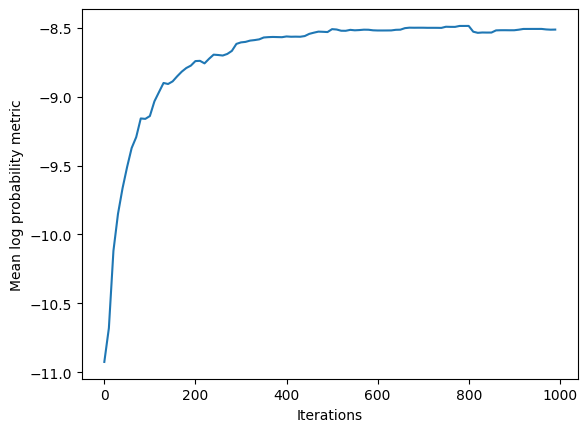


Inference time: 36 seconds


In [9]:
start=time.time()
np.random.seed(0) # to get reproducible results (because of the random initialization of lambda)
trained_lamb, log_p = svi.forward(train_dataset_onehot, eval=True, test_dat_obs=test_dataset_w_obs, test_dat_ho=test_dataset_w_ho, graph=True)
end=time.time()
print("\nInference time:", int(end-start), "seconds")

# saving trained_lamb
with open(save_path+CHOSEN_DATASET+"_lambda", "wb") as fp4:  
    pickle.dump(trained_lamb, fp4)

In [10]:
topics = svi.pred_topics(trained_lamb, nb_words=10, display_topics=True)

# saving the topics
with open(save_path+CHOSEN_DATASET+"_topics", "wb") as fp5:  
    pickle.dump(topics, fp5)


Top 10 words for topic n°1
['maria', 'keyboard', 'archbishop', 'clinical', 'typing', 'gonorrhea', 'hicnet', 'oxalic', 'marriage', 'wrist']

Top 10 words for topic n°2
['comprehensive', 'lord', 'schism', 'influenza', 'sins', 'restraint', 'ahmadiyya', 'lefebvre', 'godhead', 'gonorrhea']


* **On a 10% sample from 20 newsgroup with a 'small' vocabulary of $\approx$ 2,100 words (and forgetting_rate=1)**

In [6]:
# Loading pre-processed data and building the parameters for SVI

CHOSEN_DATASET="20NG_2_themes_small_vocab"

Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path = loading_preprocessed_data(CHOSEN_DATASET)

In [8]:
svi = stochastic_variational_inference(params) 

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.97it/s]


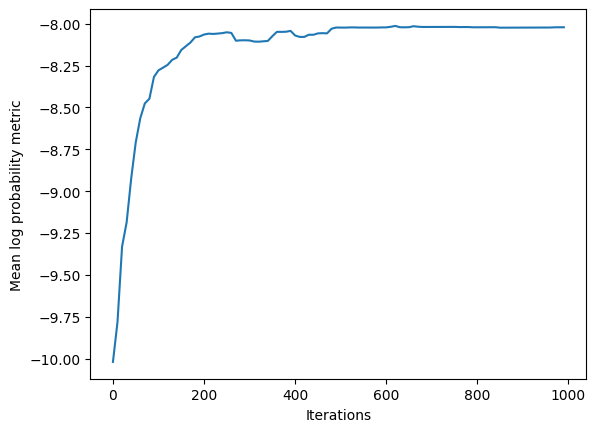


Inference time: 18 seconds


In [11]:
start=time.time()
np.random.seed(0) # to get reproducible results (because of the random initialization of lambda)
trained_lamb, log_p = svi.forward(train_dataset_onehot, eval=True, test_dat_obs=test_dataset_w_obs, test_dat_ho=test_dataset_w_ho, graph=True)
end=time.time()
print("\nInference time:", int(end-start), "seconds")

# saving trained_lamb
with open(save_path+CHOSEN_DATASET+"_lambda", "wb") as fp4:  
    pickle.dump(trained_lamb, fp4)

In [12]:
topics = svi.pred_topics(trained_lamb, nb_words=10, display_topics=True)

# saving the topics
with open(save_path+CHOSEN_DATASET+"_topics", "wb") as fp5:  
    pickle.dump(topics, fp5)


Top 10 words for topic n°1
['maria', 'candida', 'infected', 'comprehensive', 'exercises', 'polio', '30pm', 'aspartame', 'shipping', 'deity']

Top 10 words for topic n°2
['keyboard', 'aids', 'children', '1993', 'pope', 'restraint', 'gonorrhea', 'avenue', 'ahmadiyya', 'clinical']


* **On 20 newsgroup (whole dataset) with K=20**

In [22]:
# Loading pre-processed data and building the parameters for SVI

CHOSEN_DATASET="20NG"

Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path = loading_preprocessed_data(CHOSEN_DATASET)

In [19]:
svi = stochastic_variational_inference(params) 

100%|█████████████████████████████████████| 1000/1000 [7:01:35<00:00, 25.30s/it]


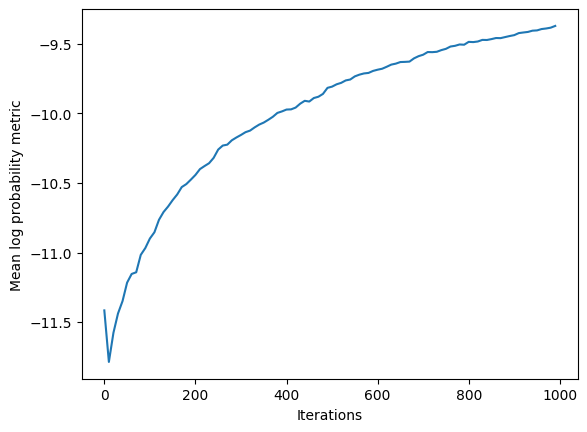


Inference time: 25295 seconds


In [20]:
# we did not fix the seed for this run
start=time.time()
trained_lamb, log_p = svi.forward(train_dataset_onehot, eval=True, test_dat_obs=test_dataset_w_obs, test_dat_ho=test_dataset_w_ho, graph=True)
end=time.time()
print("\nInference time:", int(end-start), "seconds")

# saving trained_lamb
with open(save_path+CHOSEN_DATASET+"_lambda_K_20", "wb") as fp4:  
    pickle.dump(trained_lamb, fp4)

In [21]:
topics = svi.pred_topics(trained_lamb, nb_words=10, display_topics=True)

# saving the topics
with open(save_path+CHOSEN_DATASET+"_topics_K_20", "wb") as fp5:  
    pickle.dump(topics, fp5)


Top 10 words for topic n°1
['kings', 'idea', 'blood', 'term', 'systems', 'cape', 'flames', 'godhead', 'algorithm', 'rychel']

Top 10 words for topic n°2
['days', 'exercises', 'list', 'making', 'wondering', 'wrong', 'weaver', 'application', 'equation', 'gospels']

Top 10 words for topic n°3
['windows', 'fredericton', 'lying', 'feel', 'games', 'approach', 'carefully', 'secular', 'hulk', 'calls']

Top 10 words for topic n°4
['russia', 'existence', 'disks', 'sydor', 'image', 'stereo', 'music', 'idea', 'cult', 'icon']

Top 10 words for topic n°5
['ottawa', 'game', 'applications', 'launched', 'series', 'hard', 'head', 'voice', 'mcconkie', 'thug']

Top 10 words for topic n°6
['president', 'guns', 'colormap', 'moncton', 'points', 'americans', 'calgary', 'flames', 'rochester', 'click']

Top 10 words for topic n°7
['people', 'jewish', 'program', 'year', 'years', 'general', 'number', 'flames', 'salvation', 'semi']

Top 10 words for topic n°8
['zoroastrians', 'workspace', 'binghamton', 'privacy',

* **On 20 newsgroup (whole dataset) with K=5 only**

In [20]:
# Loading pre-processed data and building the parameters for SVI

CHOSEN_DATASET="20NG"
Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path = loading_preprocessed_data(CHOSEN_DATASET)
params['K']=5
svi = stochastic_variational_inference(params) 

100%|█████████████████████████████████████| 1000/1000 [4:53:01<00:00, 17.58s/it]


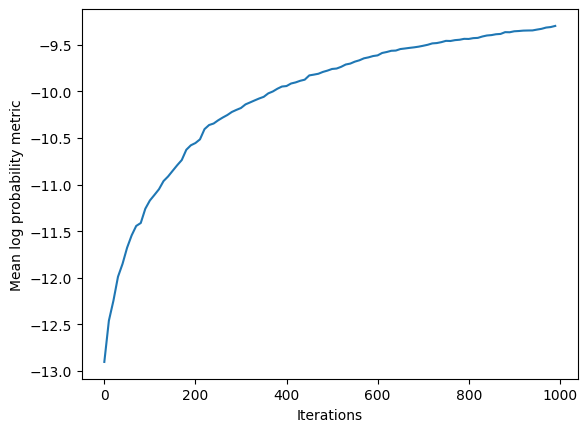


Inference time: 17581 seconds


In [10]:
# we did not fix the seed for this run
start=time.time()
trained_lamb, log_p = svi.forward(train_dataset_onehot, eval=True, test_dat_obs=test_dataset_w_obs, test_dat_ho=test_dataset_w_ho, graph=True)
end=time.time()
print("\nInference time:", int(end-start), "seconds")

# saving trained_lamb
with open(save_path+CHOSEN_DATASET+"_lambda_K_5", "wb") as fp4:  
    pickle.dump(trained_lamb, fp4)

In [11]:
topics = svi.pred_topics(trained_lamb, nb_words=10, display_topics=True)

# saving the topics
with open(save_path+CHOSEN_DATASET+"_topics_K_5", "wb") as fp5:  
    pickle.dump(topics, fp5)


Top 10 words for topic n°1
['ripem', 'larson', 'scsi', 'agrep', 'forged', 'paradox', 'courses', 'libx11', 'open', 'list']

Top 10 words for topic n°2
['physical', 'barbara', 'braking', 'level', 'grafsys', 'needed', 'orbeli', 'problem', 'standard', 'left']

Top 10 words for topic n°3
['anania', 'theory', 'windows', 'tanks', 'toolkit', 'ranger', 'venera', 'court', 'sheets', 'drive']

Top 10 words for topic n°4
['plplot', 'xlib', 'bayonet', 'mariner', 'fluids', 'theory', 'ezekiel', 'cooper', 'pittsburg', 'people']

Top 10 words for topic n°5
['probes', 'cranston', 'physicist', 'luna', 'time', 'prefix', 'runs', 'patent', 'providence', 'days']


* **On BBC news, with forgetting_rate=1**

In [8]:
# Loading pre-processed data and building the parameters for SVI

CHOSEN_DATASET="bbc"

Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path = loading_preprocessed_data(CHOSEN_DATASET)

In [19]:
svi = stochastic_variational_inference(params) 

100%|█████████████████████████████████████| 1000/1000 [2:39:13<00:00,  9.55s/it]


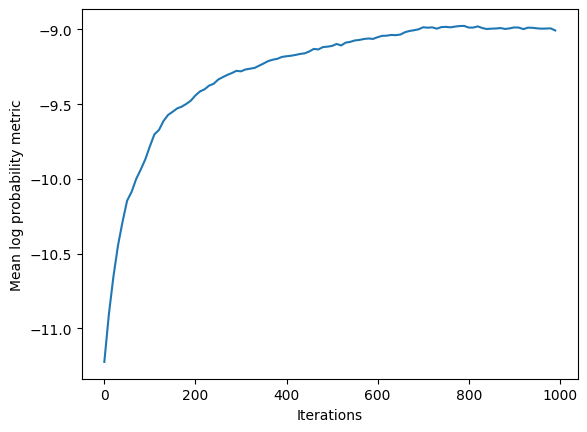


Inference time: 9554 seconds


In [20]:
# we did not fix the seed for this run
start=time.time()
trained_lamb_1, log_p = svi.forward(train_dataset_onehot, eval=True, test_dat_obs=test_dataset_w_obs, test_dat_ho=test_dataset_w_ho, graph=True)
end=time.time()
print("\nInference time:", int(end-start), "seconds")

# saving trained_lamb
with open(save_path+CHOSEN_DATASET+"_lambda_fr_1", "wb") as f4:  
    pickle.dump(trained_lamb_1, f4)

In [21]:
topics_1 = svi.pred_topics(trained_lamb_1, nb_words=10, display_topics=True)

# saving the topics
with open(save_path+CHOSEN_DATASET+"_topics_fr_1", "wb") as fp5_a:  
    pickle.dump(topics_1, fp5_a)


Top 10 words for topic n°1
['kilroy', 'ballet', 'cash', 'week', 'virus', 'davis', 'alan', 'compensation', 'phishing', 'report']

Top 10 words for topic n°2
['vote', 'iraq', 'attacks', 'mock', 'bond', 'vieira', 'linux', 'blinkx', 'housing', 'apple']

Top 10 words for topic n°3
['howard', 'india', 'asylum', 'tories', 'espn', 'awards', 'control', 'double', 'turkey', 'patients']

Top 10 words for topic n°4
['angels', 'harriers', 'labour', 'mercedes', 'lenovo', 'kilroy', 'people', 'wales', 'learning', 'athens']

Top 10 words for topic n°5
['sales', 'ukip', 'rusedski', 'agreement', 'government', 'price', 'festival', 'real', 'lions', 'students']


* **On BBC news, with forgetting_rate=0.8**

In [10]:
# Loading pre-processed data and building the parameters for SVI

CHOSEN_DATASET="bbc"
Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path = loading_preprocessed_data(CHOSEN_DATASET)
params['forgetting_rate']=0.8
svi = stochastic_variational_inference(params) 

100%|█████████████████████████████████████| 1000/1000 [2:58:47<00:00, 10.73s/it]


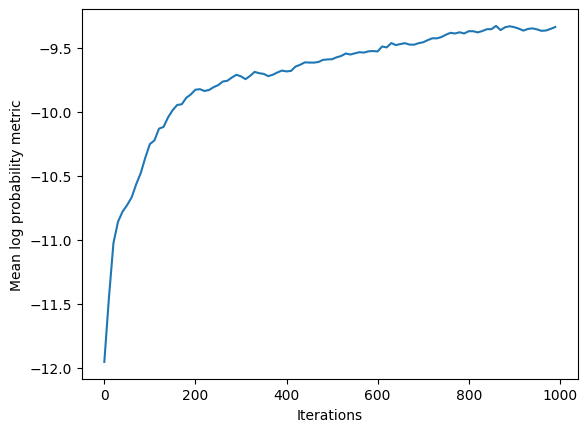


Inference time: 10727 seconds


In [12]:
# we did not fix the seed for this run
start=time.time()
trained_lamb_0_8, log_p = svi.forward(train_dataset_onehot, eval=True, test_dat_obs=test_dataset_w_obs, test_dat_ho=test_dataset_w_ho, graph=True)
end=time.time()
print("\nInference time:", int(end-start), "seconds")

# saving trained_lamb
with open(save_path+CHOSEN_DATASET+"_lambda_fr_0_8", "wb") as f3:  
    pickle.dump(trained_lamb_0_8, f3)

In [13]:
topics_0_8 = svi.pred_topics(trained_lamb_0_8, nb_words=10, display_topics=True)

# saving the topics
with open(save_path+CHOSEN_DATASET+"_topics_fr_0_8", "wb") as f4:  
    pickle.dump(topics_0_8, f4)


Top 10 words for topic n°1
['audience', 'mouse', 'sales', 'channel', 'isinbayeva', 'carson', 'japan', 'bonus', 'venezuela', 'tremor']

Top 10 words for topic n°2
['tour', 'csos', 'time', 'mcallister', 'cinemas', 'henman', 'print', 'programmes', 'arms', 'meldrum']

Top 10 words for topic n°3
['campbell', 'police', 'telewest', 'joint', 'phishing', 'icann', 'diageo', 'delta', 'hailey', 'conventional']

Top 10 words for topic n°4
['broadband', 'williams', 'online', 'labour', 'jamie', 'choice', 'star', 'premium', 'turkcell', 'justice']

Top 10 words for topic n°5
['attacks', 'pensions', 'edwards', 'laws', 'varig', 'boeing', 'economy', 'speech', 'evans', 'appeal']


* **On BBC news, with forgetting_rate=0.6**

In [14]:
# Loading pre-processed data and building the parameters for SVI

CHOSEN_DATASET="bbc"
Vocabulary, train_dataset_onehot, test_dataset_w_obs, test_dataset_w_ho, params, save_path = loading_preprocessed_data(CHOSEN_DATASET)
params['forgetting_rate']=0.6
svi = stochastic_variational_inference(params) 

100%|█████████████████████████████████████| 1000/1000 [2:54:23<00:00, 10.46s/it]


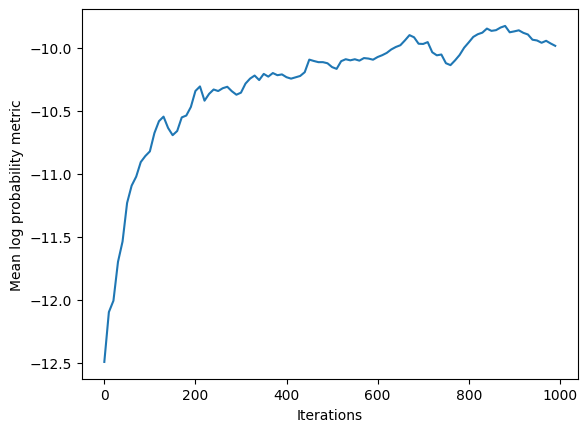


Inference time: 10463 seconds


In [15]:
# we did not fix the seed for this run
start=time.time()
trained_lamb_0_6, log_p = svi.forward(train_dataset_onehot, eval=True, test_dat_obs=test_dataset_w_obs, test_dat_ho=test_dataset_w_ho, graph=True)
end=time.time()
print("\nInference time:", int(end-start), "seconds")

# saving trained_lamb
with open(save_path+CHOSEN_DATASET+"_lambda_fr_0_6", "wb") as f1:  
    pickle.dump(trained_lamb_0_6, f1)

In [16]:
topics_0_6 = svi.pred_topics(trained_lamb_0_6, nb_words=10, display_topics=True)

# saving the topics
with open(save_path+CHOSEN_DATASET+"_topics_fr_0_6", "wb") as f2:  
    pickle.dump(topics_0_6, f2)


Top 10 words for topic n°1
['ofcom', 'texas', 'seed', 'robinson', 'forgotten', 'future', 'virgin', 'mcilroy', 'increase', 'succeed']

Top 10 words for topic n°2
['yukos', 'devices', 'officials', 'bond', 'demands', 'multimedia', 'female', 'staff', 'athens', 'decisions']

Top 10 words for topic n°3
['yushchenko', 'duty', 'rifle', 'viktor', 'penalties', 'spitzer', 'fiat', 'ongc', 'argentine', 'copyright']

Top 10 words for topic n°4
['arms', 'mansfield', 'wood', 'guilty', 'scott', 'melzer', 'promises', 'recession', 'disaster', 'pigs']

Top 10 words for topic n°5
['bloggers', 'album', 'phishing', 'arash', 'square', 'agassi', 'adoption', 'bids', 'customers', 'rebellion']


* **Comments on the experimental results**

**Evolution of the log probability curve**

As expected the log probability is almost monotically increasing through learning (some small fluctuations appear but this is common when using stochastic optimization), and it does stabilize at the end, just like in the paper. We also tested empirically that the distributions computed in the function log\_prob did, indeed, sum to 1, which was the case. 

**Comment on the length of the vocabulary**

We did a first experiment on 10% of the 20 newsgroup dataset, comparing results for a bigger vocabulary ($\approx$ 3,700 words) to the results for a smaller one ($\approx$ 2,100 words). We found that a smaller vocabulary led to a log probability curve that converges to a higher final log probability value ($\approx$-8) while a larger vocabulary led to a final value of -8.5. This could come from the fact that, when using a smaller vocabulary, each word will be granted a higher probability by SVI than the same words in a larger vocabulary (as a distribution sums to 1). Furthermore, as we expected, using a smaller vocabulary ($\frac{2100}{3700}\approx57\%$), leads to a more computationally effective algorithm, with inference time going from 36 seconds to 18 seconds when we replace the large vocabulary by the smaller one. Therefore, vocabulary's length and running time seem to be linearly related. Still, as we have to make sure that we keep enough words to converge to satisfying and diverse topics, finding the ideal length for the vocabulary is delicate. 

When looking at topic results, it seems that $\approx$ 75% of both topics top 10 words have strong semantic value, directly related to the 2 thematic labels (religion and medecine). Results for a larger vocabulary seem to have slightly less words related to medecine, when compared to results for the small vocabulary, but no clear superiority in the results appear. 

Finally, let us remark that the topic results were highly dependent on the chosen seed before running the SVI inference. This proves that the initial random initialization of $\lambda^{(0)}$ is very impactful on the topic results.  

**Impact of the K hyperparameter**

We then tried to infer topics on the whole 20 newsgroup dataset, first for K=20 (which is the total number of thematic labels), then for a much smaller K (K=5). We noticed that inferring a smaller number of topics did not significantly reduce the number of iterations required to converge, as in both cases our algorithm failed to converge within 1000 iterations and both reached the final value of $\approx -9.5$. We still noticed, as we expected, that each iteration seems to be cheaper in terms of computation when K is smaller. Indeed, for 1000 iterations, we found an inference time of $\approx 17,500$ seconds $\approx$ 4h45 for K=5 and an inference time of $\approx$ 25,200 seconds $\approx$ 7h for K=20. 

Let us note that neither topic results were very convincing. For K=5, very inconsistent lexical fields were grouped together. As for topic results for K=20, the original thematic labels were easier to distinguish but with lots of noise. For instance, we had topics that were quite relevant such as topic n°14 ('space', 'portable', 'nasa', 'widget', 'adirondack', 'breton', 'email', 'spacecraft', 'program', 'wolverine') that seems to group words from the space and tech lexical fields, while others like topic n°20 ('args', 'firearms', 'answer', 'windows', 'percent', 'tinnitus', 'hope', 'pixel', 'tracking', 'india') were displaying words of very numerous and diverse themes such as guns, tech, medecine, politics, etc. Actually, most of our early experiments seemed to show that more noisy words were present in the topics top 10 words inferred on 20 newsgroup when compared to BBC news. This could imply that the dataset's quality (the BBC news articles gave a much cleaner vocabulary than the "tweet" like messages from 20 newsgroup) is crucial to improve the algorithm's results. This led us to perform later experiments on BBC news rather than on 20 newsgroup. 

**Impact of the forgetting rate (in the learning rate)**

To test for the impact of the learning rate on the log probability curve, we tested various values of the **forgetting rate** among $\{0.6, 0.8, 1\}$ and found that a smaller forgetting rate=0.6 (like recommended in the paper) led to much less stable learning and slower convergence as we forget faster the old information. Indeed, we found that the larger the forgetting rate, the smoother the log probability curve's increase and the earlier its clear convergence. For instance, for BBC news with forgetting rate = 1, the convergence towards the value of -9 happens as soon as iteration 700 while for forgetting rate = 0.8 or 0.6, no clear convergence happens before iteration 1000 and final log probability values are $\approx$ -9.4 and -10 instead of -9. 

As for the impact on the inferred topics, they, as well, were very sensitive to the forgetting\_rate value. It appeared to us that the topics found for a larger forgetting rate (forgetting\_rate = 1) were better as most of the topics top 10 words had strong semantic values with a meaning close to the 5 thematic labels of the dataset (business, entertainment, politics, sport and tech). Indeed, the inferred topics top 10 words for forgetting rate = 1 could be related to the following themes:

* topic n°1: sport and tech

* topic n°2: politics and tech

* topic n°3: politics

* topic n°4: entertainment and sport

* topic n°5: business, entertainment and politics

It seems that launching the same inference algorithm with smaller forgetting\_rate values on the BBC news dataset, slightly harmed the topic results. Indeed, less top 10 words had semantic values that were easily relatable to one of the 5 thematic labels. For instance, among the results found for forgetting\_rate=0.8, the top 10 words of topic n°3 ('campbell', 'police', 'telewest', 'joint', 'phishing', 'icann', 'diageo', 'delta', 'hailey', 'conventional') were not easily associated to a thematic label and words with low semantic values like 'joint' were highly ranked in the found distributions. However, this topic appreciation remains subjective (even more so, as the results depend on the random initialization of $\lambda^{(0)}$).

**Comments on clustering ability**

Another observation on the topic results is that, both for 20 newsgroup and BBC news, even among the semantically relevant words, we found that words belonging to a same lexical field were not always grouped together in a same topic's top 10 words. For instance, when using media posts labelled as "medecine" and "religion" in 20 newsgroup, we could find in a same topic both medical and political terms grouped together as top 10 words. Similarly in the case of BBC news, even with forgetting rate = 1, we found that most inferred topics top 10 words could be related to at least 2 out of the 5 thematic labels of the dataset, as detailed above. Hence, it seems that we managed to achieve, through hyperparameter tuning and clean dataset selection, a quite satisfying level of thematic detection, while failing at performing proper clustering of found lexical fields. Our topic results were thus different and less satisfying that those in the paper because of this phenomenon. Yet, the fact that our datasets were much smaller in size than those used in the paper limited our ability to compare objectively the paper's results to ours. 

**Conclusion on our experimental results**

As we saw, the topics obtained are very sensitive to any hyperparameter we may change, from the vocabulary's length and content (through the choice of stop words and frequency filters), to the number of topics K to evaluate, to the learning rate's calibration. As we also showed, the given metric in the paper is not enough to chose the ideal combination of such hyperparameters which leaves space to mutliple (and costly) comparative trainings to find better results or heuristics. This is a clear shortcoming of stochastic variational inference for LDA. 

## 5) Limits and extensions

Markov Chain Monte Carlo (MCMC) methods are commonly used for Bayesian inference, generating samples from the posterior distribution. Despite being able to accurately estimate posterior distributions with multiple modes, MCMC can be computationally expensive. Variational Inference, on the other hand, is an optimization method that approximates the posterior distribution with a simpler distribution and is often preferred over MCMC due to its computational efficiency. 


This article introduced Stochastic Variational Inference (SVI) as an extension of Variational Inference (VI) that incorporates stochastic optimization techniques. Compared to VI, SVI is more scalable, especially for large datasets, and more efficient for high-dimensional models. Additionally, SVI is a suitable method for online learning situations where new data is frequently added.


In our article, several assumptions were made regarding the model, such as the distributions being from the exponential family and only considering mean field family. To optimize the objective function more efficiently and achieve faster convergence, the authors use natural gradient. The computation of the Fisher information matrix is required for calculating the natural gradient. However, the assumptions made on the model, such as the restriction to the exponential family and the mean field family, eliminate the Fisher matrix. In general, computing the Fisher information matrix can be challenging, particularly for complex models with numerous parameters. They also limit the applicability of SVI to models outside these families.

Our article showcases the application of SVI in a specific domain, namely topic modeling using LDA. However, SVI is not limited to this application and can be used for other purposes as well. In our LDA model, we assumed exchangeable priors for $\beta_k$ and $\theta_d$, where each parameter had a unique value ($\eta$ and $\alpha$). Although this assumption is simpler, non-exchangeable priors may offer better performance in some cases.

One challenge with LDA is that it requires specifying the number of topics in advance, which is often unknown in practice. Cross-validation can be used to address this issue, but it may not be feasible for large datasets. Another limitation of LDA is that it assumes that all topics are present in the data and that each document is generated from a mixture of these pre-specified topics. This means that LDA may not be able to identify new topics that have not been previously observed in the data.

To overcome these limitations, the Hierarchical Dirichlet Process (HDP) was introduced in our reference article as a non-parametric alternative to LDA. The HDP assumes an infinite number of topics and allows the number of topics to be learned from the data. This makes it more flexible and scalable than LDA, as it can discover new topics if needed. However, HDP can be computationally more expensive and complex to implement than LDA. In general, the choice between LDA and HDP depends on the specific analytical needs. LDA is a good choice when the number of topics is known in advance, and the goal is to identify the most likely topics present in the data. HDP is a good choice when the number of topics is unknown.

Finally, the presented algorithm is designed based on conjugate exponential family models, which are powerful but have limitations in capturing correlations between topics. To solve this problem, more elaborate priors are used in non-conjugate models to extend the algorithm to general cases. Here, we sample from the data uniformly, but another possible extension is to sample non-uniformly to better focus on more informative data points. Finally, we can also study and attempt to improve our estimations of the gradient, which are more computable than the natural gradient and do not require any assumptions such as the distributions belonging to the exponential family or being limited to the mean field family.